In [2]:
import numpy as np
import torch
from torch import nn
import random
import matplotlib.pyplot as plt
from ripser import Rips


#DATA = np.array([np.array([1,1]),np.array([1,5]), np.array([5,1]),  np.array([5,5])]) # np.array([5,1]), np.array([2,3]), np.array([4,3]),
#DATA = np.random.random((100,2))

device = 'cuda'

XOR_DATA = [[0, 0], [1, 0], [0, 1], [1, 1]]
XOR_TARGETS = [[0], [1], [1], [0]]

X = torch.tensor(XOR_DATA, dtype=torch.float32).to(device)
Y = torch.tensor(XOR_TARGETS, dtype=torch.float32).to(device)


class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(2, 2, bias=True),
            nn.Sigmoid(),
            nn.Linear(2, 1, bias=True),
            nn.Sigmoid()
        ).to(device)

    def forward(self, x):
        return self.layers(x)


def norm(vec):
    return torch.nn.functional.normalize(vec, p=2, dim=1)


def mag(vec):
    return vec.norm(p=2, dim=1, keepdim=True)


torch.manual_seed(42)
#trainloader = torch.utils.data.DataLoader(list(zip(X, Y)), batch_size=1)
#mlp = MLP()
#
#loss_function = nn.MSELoss().to(device)
#optimizer = torch.optim.SGD(mlp.parameters(), lr=0.1)
#
#for epoch in range(0, 10000):
#    current_loss = 0.0
#    for i, data in enumerate(trainloader, 0):
#        inputs, targets = data
#        optimizer.zero_grad()
#        outputs = mlp(inputs)
#        loss = loss_function(outputs, targets)
#        loss.backward()
#        optimizer.step()
#        current_loss += loss.item()
#
#print(mlp.forward(X))
#print('Training process has finished')

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)
[0.0, 1.7074395418167114, 0.0, 1.0247621536254883, 0.0, 1.0341840982437134, 0.0, 1.629154920578003, 0.0, 1.7074395418167114]
[0.0, 2.029191017150879, 0.0, 1.675443172454834, 0.0, 1.8549875020980835, 0.0, 1.9911167621612549, 0.0, 2.029191017150879]
[0.0, 1.9990912675857544, 0.0, 1.0731796026229858, 0.0, 1.2951205968856812, 0.0, 1.8183866739273071, 0.0, 1.9990912675857544]
[0.0, 2.1371591091156006, 0.0, 1.1654890775680542, 0.0, 1.6097074747085571, 0.0, 1.830727458000183, 0.0, 2.1371591091156006]
[0.0, 3.2509238719940186, 0.0, 1.3154478073120117, 0.0, 1.5875234603881836, 0.0, 2.357950448989868, 0.0, 3.2509238719940186]
[0.0, 2.2540061473846436, 0.0, 1.1895976066589355, 0.0, 1.5917882919311523, 0.0, 1.6415815353393555, 0.0, 2.2540061473846436]
[0.0, 2.494013786315918, 0.0, 1.3665817975997925, 0.0, 1.6850864887237549, 0.0, 1.7763252258300781, 0.0, 2.494013786315918]
[0.0, 2.3671352863311768, 0.0, 1.645516037

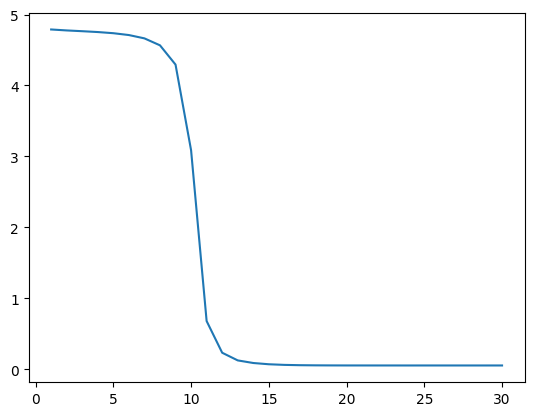

In [22]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = torch.nn.Sequential(
            nn.Linear(10, 10, bias=False),
            nn.LeakyReLU(),
            nn.Linear(10, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 2, bias=False),
            nn.LeakyReLU(),
            nn.Linear(2, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 10, bias=False),
            nn.LeakyReLU(),
            nn.Linear(10, 10, bias=False)
        ).to(device)

    def forward(self, x):
        return self.layers(x)


class AETrainer():
    def __init__(self, model):
        self.model = model

    def train(self, training_data):
        train_loader = torch.utils.data.DataLoader(list(zip(training_data, training_data)), batch_size=1, shuffle=True)
        loss_function = nn.L1Loss(reduction='sum').to(device)
        optimizer = torch.optim.SGD(self.model.parameters(), lr=0.001)
        losses = []
        for epoch in range(0, 30):
            epoch_loss = []
            for i, data in enumerate(train_loader, 0):
                inputs, targets = data
                optimizer.zero_grad()
                inputs = norm(inputs)
                targets = torch.nn.functional.normalize(targets, p=2, dim=1)
                outputs = self.model(inputs)
                loss = loss_function(outputs, targets) * loss_function(outputs, targets)
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())
            losses.append(sum(epoch_loss) / len(epoch_loss))
        return losses

    def model(self):
        return self.model()


X = (5, 10)
Y = (20, 25)


def my_plot(epochs, loss):
    plt.plot(epochs, loss)


rips = Rips()

training_samples = []
validation_data = []
outlier_data_set = []
for i in range(1000):
    training_samples.append([random.uniform(X[0], X[1]), random.uniform(Y[0], Y[1])])

transformed_data = []
t_validation_data = []
t_outlier_data = []

for i in range(200):
    validation_data.append([random.uniform(X[0], X[1]), random.uniform(Y[0], Y[1])])

for i in range(50):
    outlier_data_set.append([random.uniform(11, 1500), random.uniform(26, 1500)])

for i in range(50):
    outlier_data_set.append([random.uniform(-1500, 4), random.uniform(-1500, 19)])

for i in range(0, 1000, 10):
    sample = training_samples[i:i + 10]
    persistence_diagram = rips.fit_transform(np.array(sample))
    # lets take the first 1d and then 4 lower dimensional features. If there are none just fill with 0.0
    t_data = []

    zero_d = persistence_diagram[0]
    one_d = persistence_diagram[0]
    points_zero = zero_d[-5:]
    points_one = one_d[-2:]

    #print(points_one[0])
    #print(points_zero[:4])
    # We need to ignore the "last" points in our collection here since they are [0,inf] are useless for our usecase.

    t_data.append(points_one[0][0])
    t_data.append(points_one[0][1])

    for x, y in points_zero[:4]:
        t_data.append(x)
        t_data.append(y)
    print(t_data)
    transformed_data.append(t_data)

for i in range(0, 200, 10):
    sample = validation_data[i:i + 10]
    t_data = []
    for x, y in sample:
        t_data.append(x)
        t_data.append(y)
    t_validation_data.append(t_data)

for i in range(0, 100, 10):
    sample = outlier_data_set[i:i + 10]
    t_data = []
    for x, y in sample:
        t_data.append(x)
        t_data.append(y)
    t_outlier_data.append(t_data)

mixin_training = transformed_data + t_outlier_data
transformed_data = torch.tensor(transformed_data, dtype=torch.float32).to(device)
t_validation_data = torch.tensor(t_validation_data, dtype=torch.float32).to(device)
t_outlier_data = torch.tensor(t_outlier_data, dtype=torch.float32).to(device)
#mixin_training = torch.tensor(mixin_training, dtype=torch.float32).to(device)

ae = AutoEncoder()
ae_trainer = AETrainer(ae)
losses = ae_trainer.train(transformed_data)
my_plot(np.linspace(1, 30, 30).astype(int), losses)
b = transformed_data[0]
#print(b)


#print(torch.nn.functional.normalize(transformed_data[0],p=2, dim=0) * transformed_data[0].norm(p=2, dim=0, keepdim=True))
#print(torch.nn.functional.normalize(transformed_data[0],p=2, dim=0))
a = ae.forward(torch.nn.functional.normalize(transformed_data[0], p=2, dim=0))
print(a)
print(a * transformed_data[0].norm(p=2, dim=0, keepdim=True))
#print(transformed_data[0])

second_x = []
second_y = []
for d in transformed_data:
    print(d)
    s = ae.forward(torch.nn.functional.normalize(d, p=2, dim=0)).cpu().detach()
    s = s * d.norm(p=2, dim=0, keepdim=True).cpu()
    print(s)
    for i in range(0, 10, 2):
        second_x.append(s[i])
        second_y.append(s[i + 1])


[[9.566791497117535, 21.696062190288607], [7.117153135265434, 20.003101885706556], [5.152146278316802, 22.136441040952075], [9.267014036032922, 20.44251838012113], [6.411218336305672, 20.90815242659478], [5.943779327653155, 20.124637116659954], [6.458514251374924, 20.45612481036768], [6.1069274694991655, 22.508637667486283], [9.21634191300982, 21.71969290668955], [8.554086709923698, 20.925366266331096], [5.742487920119023, 24.948025332686104], [5.860835123801582, 23.276767143717972], [8.887520859524006, 20.869836562437822], [8.537391642169155, 21.036897826608875], [9.708076379717252, 24.852221156431778], [8.757102151824725, 20.43324915922193], [8.43550821003382, 22.38492768913534], [7.763524533746692, 20.29081955892722], [7.948117498053213, 23.84219089298596], [6.218978615360658, 21.318124984220145], [9.483203684956901, 22.530590936600326], [9.583671124039089, 23.79821711139462], [9.236616939283783, 21.259161746335216], [6.42152587246326, 20.895172559415897], [8.60407806147881, 22.7153

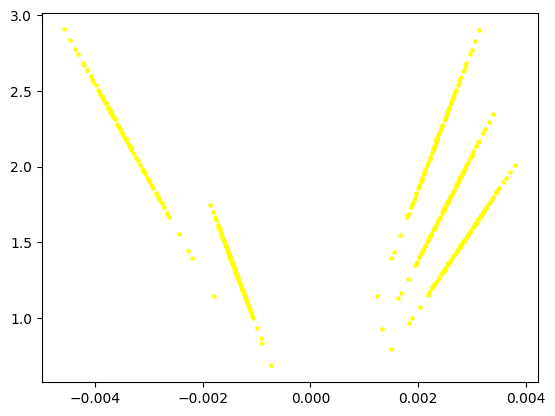

In [23]:

figure, axes = plt.subplots()
#axes.set(xlim=(5, 10), ylim=(20, 25))
uc_3 = plt.Rectangle((5, 10), 5, 5, fill=False)
print(training_samples)
#new_x = []
#new_y = []
#for z in training_samples:
#    new_x.append(z[0])
#    new_y.append(z[1])
#points_1 = plt.scatter(new_x,
#                       new_y,
#                       color="red", s=10)
points_2 = plt.scatter(second_x, second_y,
                       color="yellow", s=5)
axes.add_artist(uc_3)
plt.show()

[0.0002657877339515835, 0.0001619326212676242, 0.00019362506282050163, 3.85176099371165e-06, 0.000857041566632688, 7.644718607480172e-06, 1.4037051187187899e-05, 0.00025146850384771824, 3.089655001531355e-05, 4.9156831664731726e-05, 4.64833174191881e-05, 0.00034576794132590294, 5.8208388509228826e-05, 6.875649773974146e-07, 4.693552909884602e-05, 0.001097553875297308, 0.00011550841009011492, 0.00010018999455496669, 0.0006590328994207084, 2.711062552407384e-05, 0.0003446473565418273, 1.3083916883260827e-06, 3.041840136575047e-05, 7.907726103439927e-05, 0.00014947200543247163, 0.0010768920183181763, 0.00017121655400842428, 0.0002849219599738717, 1.0145442502107471e-05, 5.624397090286948e-06, 0.0001315540139330551, 0.0016800236189737916, 0.00015333140618167818, 7.086750315465906e-07, 3.261609163018875e-05, 3.5669868339027744e-06, 0.00013859548198524863, 0.00018830875342246145, 0.00030777411302551627, 0.00031747788307256997, 9.265718836104497e-05, 2.2091717255534604e-05, 0.0005411379388533

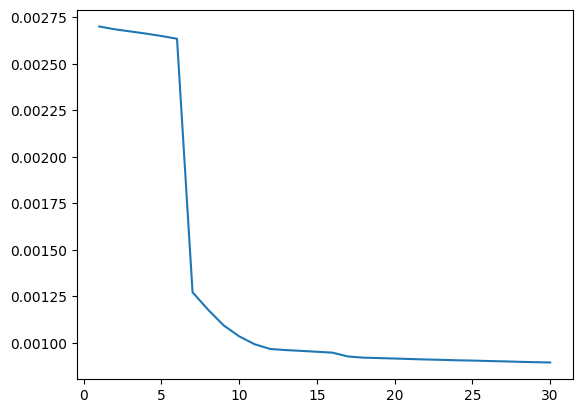

In [27]:
from numpy import sqrt, quantile


class DeepSVDD(nn.Module):
    def __init__(self, autoencoder):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(10, 10, bias=False),
            nn.LeakyReLU(),
            nn.Linear(10, 5, bias=False),
            nn.LeakyReLU(),
            nn.Linear(5, 2, bias=False)
        ).to(device)
        net_dict = self.state_dict()
        ae_dict = ae.state_dict()
        ae_dict = {k: v for k, v in ae_dict.items() if k in net_dict}
        net_dict.update(ae_dict)
        self.load_state_dict(net_dict)

    def forward(self, x):
        return self.layers(x)


# Trainer can train models for either soft-boundary Deep SVDD or One-Class Deep SVDD
class DeepSVDDTrainer:
    def __init__(self, model, goal, c_size):
        self.model = model
        self.goal = goal
        self.c = torch.tensor([0] * c_size, dtype=torch.float32, device=device)
        self.R = torch.tensor(0, dtype=torch.float32, device=device)

    def train(self, training_data):
        optimizer = torch.optim.Adam(dsvdd.parameters(), lr=0.00001)
        train_loader = torch.utils.data.DataLoader(list(zip(training_data, training_data)), batch_size=1)
        warmup_epoch = 5
        nu = 0.1

        losses = []

        for epoch in range(30):
            epoch_loss = []
            keks = []
            for data in train_loader:
                inputs, targets = data
                optimizer.zero_grad()
                outputs = dsvdd.forward(norm(inputs))
                dist = torch.sum((outputs - self.c) ** 2, dim=1)
                keks.append(dist.item())
                if self.goal == 'one-class':
                    loss = torch.mean(dist)
                else:
                    scores = dist - self.R ** 2
                    # Use default nu of 0.1 for now
                    loss = self.R ** 2 + (1 / nu) * torch.mean(torch.max(torch.zeros_like(scores), scores))
                loss.backward()
                optimizer.step()
                epoch_loss.append(loss.item())
            if epoch >= warmup_epoch and epoch % warmup_epoch == 0:
                print(keks)
                print(quantile(sqrt(keks), 1 - nu))
                self.R = torch.tensor(quantile(sqrt(keks), 1 - nu))
            losses.append(sum(epoch_loss) / len(epoch_loss))
        return losses

    def set_center(self, transformed_data):
        with torch.no_grad():
            for x in transformed_data:
                self.c += dsvdd.forward(torch.nn.functional.normalize(x, p=2, dim=0))

        self.c /= len(transformed_data)

    # First copy weights from autoencoder to DeepSVDD network


#mixin outliers with transformed data

dsvdd = DeepSVDD(ae)
dsvdd_trainer = DeepSVDDTrainer(dsvdd, 'soft-boundary', 2)
dsvdd_trainer.set_center(transformed_data)
losses = dsvdd_trainer.train(transformed_data)
my_plot(np.linspace(1, 30, 30).astype(int), losses)

tensor(0.0250, dtype=torch.float64)
tensor([ 0.7889, -0.0745], device='cuda:0')


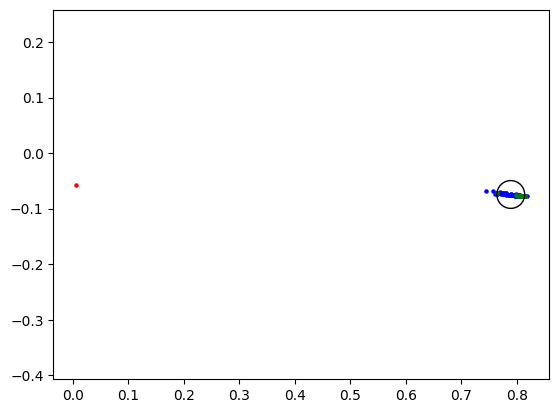

In [28]:
figure, axes = plt.subplots()
uc_3 = plt.Circle(dsvdd_trainer.c, dsvdd_trainer.R, fill=False)

new_x = []
a_new_x = []
new_y = []
a_new_y = []

print(dsvdd_trainer.R)
print(dsvdd_trainer.c)
for data in transformed_data[-10:]:
    map = dsvdd.forward(torch.nn.functional.normalize(data, p=2, dim=0)).cpu().detach().numpy()
    a_new_x.append(map[0])
    a_new_y.append(map[1])

for data in transformed_data[:-10]:
    map = dsvdd.forward(torch.nn.functional.normalize(data, p=2, dim=0)).cpu().detach().numpy()
    new_x.append(map[0])
    new_y.append(map[1])


#print(mixin_training[-10:])
anomalous = transformed_data[0].cpu().detach().numpy()
#
anomalous[0] = random.random() * -20
anomalous[1] = random.random() * -15
anomalous = torch.tensor(anomalous, dtype=torch.float32, device=device)
an = dsvdd.forward(torch.nn.functional.normalize(anomalous, p=2, dim=0)).cpu().detach().numpy()
center = dsvdd_trainer.c.cpu().detach().numpy()
points_2 = plt.scatter(new_x, new_y,
                       color="blue", s=5)
points_3 = plt.scatter(a_new_x, a_new_y,
                       color="green", s=5)
#print(new_x)
#print(new_y)
plt.scatter(an[0], an[1],
            color="red", s=5)
plt.scatter(center[0], center[1],
            color="blue", s=5)
#axes.add_artist(uc_3)
plt.gca().add_patch(uc_3)
plt.axis('equal')
plt.show()
